<a href="https://colab.research.google.com/github/Integraloflnx/Pokemon_Regression/blob/main/Pokemon_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><img src="https://drive.google.com/uc?id=1gNm97UnUJomO64urX3ubtHyiJv_WgI8A"/></center>



# <center> <font size = "25"> **Predicting Pokemon Weight**

## <font size = "6"> **Introduction**

In this project, the goal is to build a linear regression model that predicts a Pokemon’s weight in kilograms using a variety of predictor variables such as height in meters, hp (health points), attack, defense, and speed. For this study I will be using the complete Pokemon dataset on the kaggle website. This dataset contains multiple categories of information for 802 Pokemon. The information contained in this dataset was gathered from the website serebii, which is a Pokemon database.

## <font size = "6">**Importing and Cleaning the Data**

### <font size = "4">**Import and View Data**

In [ ]:
#Import necessary modules for analysis

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import math
from statsmodels.formula.api import ols
from statsmodels.api import qqplot
from scipy import stats
from scipy.stats import boxcox
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.options.mode.chained_assignment = None

In [ ]:
#Read in the data
url = "https://github.com/Integraloflnx/Pokemon_Regression_Project/blob/main/data/pokemon.csv?raw=true"
df = pd.read_csv(url)

<font size = "3"> Now that our data is loaded in, we will first take a look at the dataframe to see what the data looks like.
<br>
<br>
<br>

In [ ]:
df.head()

,abilities,against_bug,against_dark,against_dragon,against_electric,against_fairy,against_fight,against_fire,against_flying,against_ghost,...,percentage_male,pokedex_number,sp_attack,sp_defense,speed,type1,type2,weight_kg,generation,is_legendary
0,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,1,65,65,45,grass,poison,6.9,1,0
1,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,2,80,80,60,grass,poison,13.0,1,0
2,"['Overgrow', 'Chlorophyll']",1.0,1.0,1.0,0.5,0.5,0.5,2.0,2.0,1.0,...,88.1,3,122,120,80,grass,poison,100.0,1,0
3,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,4,60,50,65,fire,NaN,8.5,1,0
4,"['Blaze', 'Solar Power']",0.5,1.0,1.0,1.0,0.5,1.0,0.5,1.0,1.0,...,88.1,5,80,65,80,fire,NaN,19.0,1,0


We are only interested in a Pokemon's name, height, weight, hp, attack, defense, and speed. Thus we will get rid of any unwanted variables so we can focus on the variables of interest. For our model we will only be looking at non-legendary Pokemon. The reasoning for excluding legendary Pokemon is that they are often extreme outliers in weight, and other categories within our predictor variables, thus many of these Pokemon have the potential to be points of influence.
<br>
<br>

In [ ]:
#Exclude legendary Pokemon and create dataframe with variables of interest
non_legendary_condition= df["is_legendary"] == 0
variables_of_interest = ["name", "weight_kg", "height_m", "hp", "attack", "defense", "speed"]
poke = df[non_legendary_condition][variables_of_interest]

We now take a look at our reduced dataframe.

In [ ]:
poke.head()

,name,weight_kg,height_m,hp,attack,defense,speed
0,Bulbasaur,6.9,0.7,45,49,49,45
1,Ivysaur,13.0,1.0,60,62,63,60
2,Venusaur,100.0,2.0,80,100,123,80
3,Charmander,8.5,0.6,39,52,43,65
4,Charmeleon,19.0,1.1,58,64,58,80


To make navigating out dataframe easier we will make the name of the pokemon our dataframe index.

In [ ]:
#Make the Pokemon's name the index
poke.set_index("name", inplace = True)
poke.head()

,weight_kg,height_m,hp,attack,defense,speed
name,,,,,,
Bulbasaur,6.9,0.7,45,49,49,45
Ivysaur,13.0,1.0,60,62,63,60
Venusaur,100.0,2.0,80,100,123,80
Charmander,8.5,0.6,39,52,43,65
Charmeleon,19.0,1.1,58,64,58,80


### <font size = "4"> **Cleaning the Data**

We will first check to see if there are any missing values in our dataframe and if so how many does each column have.

In [ ]:
#Check which columns have NAs
poke.isna().any()

weight_kg     True
height_m      True
hp           False
attack       False
defense      False
speed        False
dtype: bool

In [ ]:
#Check how many NAs each columns has 
poke.isna().sum()

weight_kg    19
height_m     19
hp            0
attack        0
defense       0
speed         0
dtype: int64

As weight is our response variable we will have to exclude these rows entirely from our analysis.

In [ ]:
#Clean dataframe, and compare the non-cleaned and cleaned dataframe
print("Shape of the uncleaned data (columns, rows): ", poke.shape)
poke.dropna(inplace = True)
print("Shape of the cleaned data (columns, rows): ", poke.shape)

Shape of the uncleaned data (columns, rows):  (731, 6)
Shape of the cleaned data (columns, rows):  (712, 6)


As we can see we remove the 19 data points with missing weight values from our dataframe. Now that our dataframe is cleaned we can finally start analyzing the data.



## <font size = "6"> **Fitting the Model**

### <font size = "4"> **Descriptive Statistics**

Before we specify the model we will first obtain summary statistics for our response variable weight. We will obtain the mean, median, standard deviation, minimum, and maximum values for weight.

In [ ]:
#Get descriptive statistics for Pokemon's weight
poke["weight_kg"].agg([np.mean, np.median, np.std, np.max, np.min])

mean       48.007163
median     24.950000
std        73.285822
amax      920.000000
amin        0.100000
Name: weight_kg, dtype: float64

As we can see the mean is 48.01 kg and the standard deviation is 73.29 kg. Our standard deviation is nearly twice the size of the mean, implying that our data is fairly spread out. Our dataset also has the potential for extreme outliers, this is evident when looking at the maximum which is 920 kg. Transformations may be needed to reduce the effect of these potential influence points.

### <font size = "4">**Scatterplot Matrix**

We will now obtain a matrix of scatterplots for the data to see if there are any immediate concerns with the data.

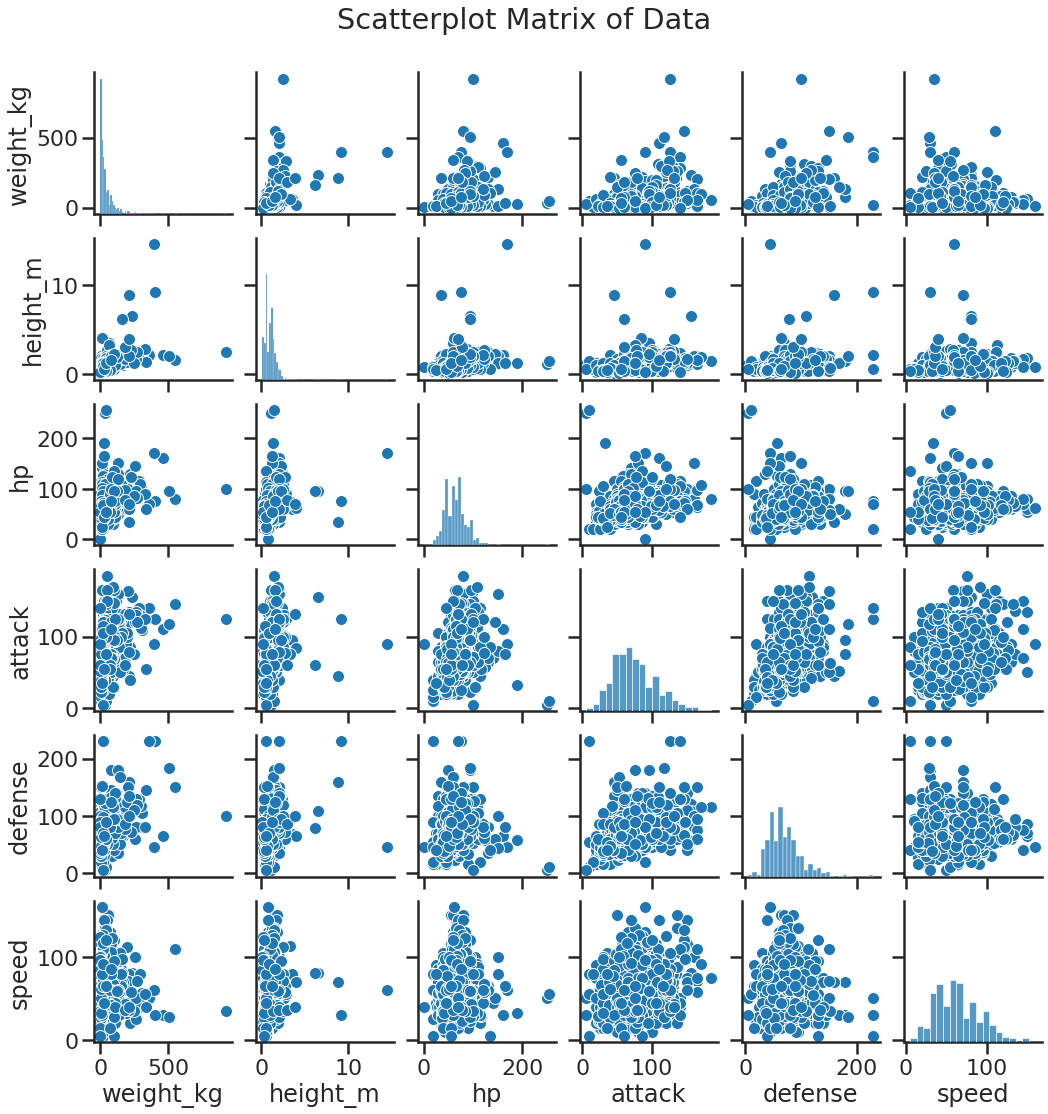

In [ ]:
#Scatterplot matrix for the Pokemon data
sns.set_context("poster")
sns.set_style("ticks")
scattermatrix = sns.pairplot(poke)
scattermatrix.fig.suptitle("Scatterplot Matrix of Data", y = 1.04)
plt.show()

Looking at the matrix of scatterplots for the Pokemon data, we see that some of the scatterplots have rather odd patterns to them that may imply non-linearity in the data. The most concerning of which being the weight vs. hp scatterplot and the weight vs. speed scatterplot. Further it seems as though there may be some multicollinearity present within our data when looking at the row of height scatterplots, but this will need to be investigated more to confirm.

### <font size = "4">**Specifying the Model**

We will be predicting the response variable weight using the Pokemon's hp, attack, defense, and speed. Thus we will have the following model:
$y= \beta_{0} + \beta_{1}x_{height} +  \beta_{2}x_{hp} + \beta_{3}x_{attack} + \beta_{4}x_{defense} - \beta_{5}x_{speed} + \epsilon$
<br>
<br>
The model assumes the following:

* The relationship between a Pokemon's weight and the regressors is approximately linear
* The error term $ϵ$ has zero mean and constant variance $σ^{2}$
* The errors are uncorrelated and normally distributed

We will now fit the model.

In [ ]:
#Fit the linear model
weightlm = ols("weight_kg ~ height_m + hp + attack + defense + speed", data = poke).fit()

We now obtain and show the summary stats for the model.

In [ ]:
#Get a summary of the linear model
weightlm_summary = weightlm.summary()
print(weightlm_summary)

                            OLS Regression Results                            
Dep. Variable:              weight_kg   R-squared:                       0.463
Model:                            OLS   Adj. R-squared:                  0.459
Method:                 Least Squares   F-statistic:                     121.6
Date:                Wed, 04 Jan 2023   Prob (F-statistic):           9.63e-93
Time:                        18:28:45   Log-Likelihood:                -3846.3
No. Observations:                 712   AIC:                             7705.
Df Residuals:                     706   BIC:                             7732.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -59.3255      8.410     -7.054      0.0

Our estimated regression line is:
<br>
$y=-59.3255 + 32.8316x_{height} +  0.4338x_{hp} + 0.3608x_{attack} + 0.5196x_{defense} - 0.3111x_{speed}$

The above model will be referred to as model 1 going forward. Immediately we see we have an intercept value of -59.3255, this value is outside of the y space and thus has no physical interpretation. Our slopes have the standard interpretation, for example with hp, given a one unit increase in a Pokemon’s hp we expect the mean of the distribution of weight to increase by 0.4338 kg holding height, attack, defense, and speed constant. Also of note is the $R^{2}$ value which has a value of 0.463 implying that 46.3% of the variation in a Pokemon’s weight is explained by the model. Before interpreting any of the hypothesis tests we will first need to validate the assumptions of the model and if necessary make any needed transformations to the data.


## <font size = "6">**Model Validation for Model 1**

Our model assumes the following:

- The relationship between a Pokemon's weight and the regressors is approximately linear
- The error term $ϵ$ has zero mean and constant variance $σ^{2}$
- The errors are uncorrelated and normally distributed

In this section we will validate these assumptions and if necessary take the proper actions.

### <font size = "4"> **Residuals Versus Fitted Values**

 We will first look at a plot of the residuals versus fitted values to see if the linearity, constant variance, or zero mean assumption are violated. To do so we will create a data frame with the predictor values, the observed values, the values predicted by the model, and the corresponding residuals.

In [ ]:
predictors = ["height_m", "hp", "attack", "defense", "speed"]

#Create a new dataframe that will contain the predicted value and residual for each data point
poke_predict = poke.copy()
poke_predict = poke_predict[["height_m", "hp", "attack", "defense", "speed", "weight_kg"]]

#Calculate the predicted values and residual
poke_predict["predicted"] = weightlm.predict(poke_predict[predictors])
poke_predict["residual"] = poke_predict["weight_kg"] - poke_predict["predicted"]

poke_predict.head()

,height_m,hp,attack,defense,speed,weight_kg,predicted,residual
name,,,,,,,,
Bulbasaur,0.7,45,49,49,45,6.9,12.319002,-5.419002
Ivysaur,1.0,60,62,63,60,13.0,35.974216,-22.974216
Venusaur,2.0,80,100,123,80,100.0,116.146645,-16.146645
Charmander,0.6,39,52,43,65,8.5,-1.823826,10.323826
Charmeleon,1.1,58,64,58,80,19.0,30.291767,-11.291767


We now display the residual versus fitted values plot

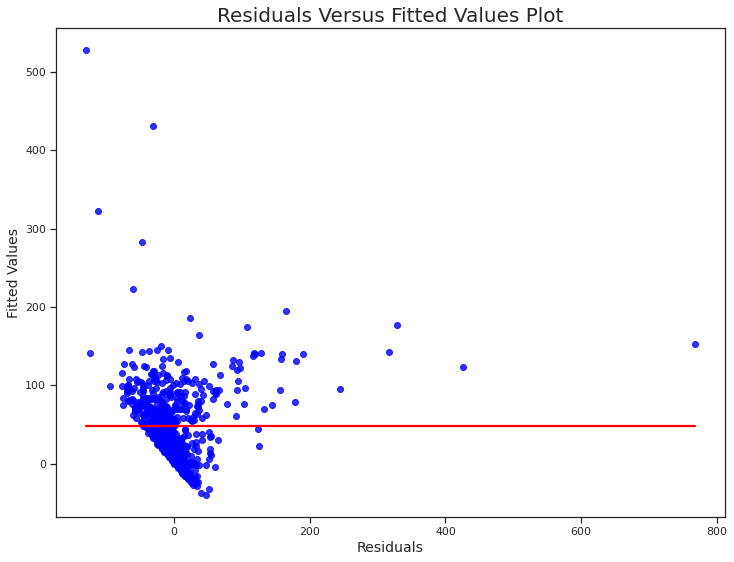

In [ ]:
#Create residual versus fitted values plot
sns.set(rc = {'figure.figsize': (12, 9)})
sns.set_style("ticks")
sns.regplot(x = poke_predict["residual"], y = poke_predict["predicted"], ci = None, scatter_kws = {"color":"blue"}, line_kws = {"color":"red"})
plt.title("Residuals Versus Fitted Values Plot", fontsize = 20)
plt.xlabel("Residuals", fontsize = 14)
plt.ylabel("Fitted Values", fontsize = 14)
plt.show()

Immediately from the residual versus fitted values plot for model 1 we see that there are many outliers. Visually, they are in the upper left portion, and also expand towards the right portion of the plot. There does also seem to be some non-linearity in the data as the points look to create a "parabola" or curved shape. Therefore, we can not verify the linearity assumption.

### <font size = "4"> **QQ Plot**

We now look at the normal Q-Q plot for model 1 to check that the errors follow a normal distribution.

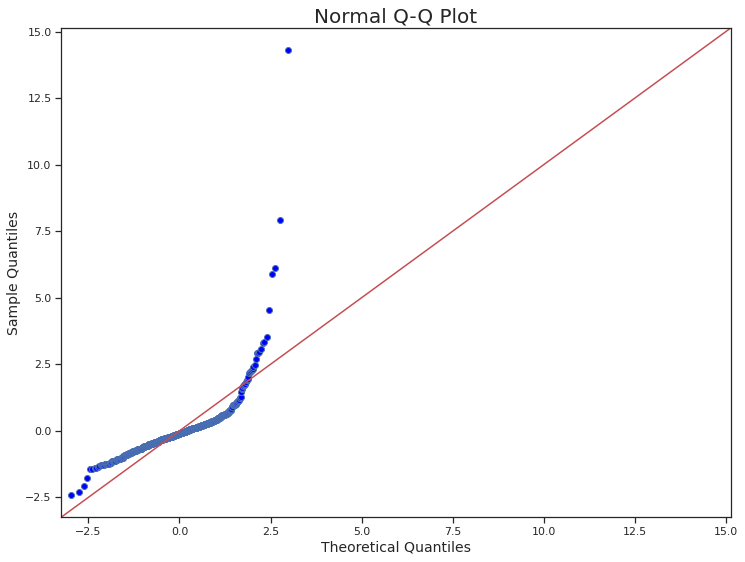

In [ ]:
#Obtain a Q-Q plot for the residuals
qqplot(data = poke_predict["residual"], fit = True, line = "45")
plt.title("Normal Q-Q Plot", fontsize = 20)
plt.xlabel("Theoretical Quantiles", fontsize = 14)
plt.ylabel("Sample Quantiles", fontsize = 14)
plt.show()

The non-linearity discussed with the residuals versus fitted values plot seems to appear once again in the normal Q-Q plot for model 1. There is also a major outlier towards the upper portion of the plot. Further the points fail to approximately fall on the straight line, thus our model violates the linearity and normality assumptions. 

## <font size = "6"> **Transforming the Data**

We will first attempt a log transformation on the response to see if it helps our data satistfy the linearity and normality assumption. If that fails we will use a box-cox transformation on the response.

### <font size = "4"> **Log Transformation on the Response** 

We create a dataframe with a log transformation applied to the response.

In [ ]:
log_data = poke.copy()

#Create a log(weight_kg) variable in the data frame
log_data["log_weight_kg"] = np.log(log_data["weight_kg"])

#Remove original response from dataframe
log_data.drop("weight_kg", axis = 1, inplace = True)

log_data = log_data[["log_weight_kg", "hp", "height_m", "attack", "defense", "speed"]]
log_data.head()

,log_weight_kg,hp,height_m,attack,defense,speed
name,,,,,,
Bulbasaur,1.931521,45,0.7,49,49,45
Ivysaur,2.564949,60,1.0,62,63,60
Venusaur,4.605170,80,2.0,100,123,80
Charmander,2.140066,39,0.6,52,43,65
Charmeleon,2.944439,58,1.1,64,58,80


Now that we have our log transformed data frame, we will fit a linear model with a log response. This model will be referred to as model 2.

In [ ]:
#Fit the log response linear model
loglm = ols("log_weight_kg ~ height_m + hp + attack + defense + speed", data = log_data).fit()
loglm_summary = loglm.summary()
print(loglm_summary)

                            OLS Regression Results                            
Dep. Variable:          log_weight_kg   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.503
Method:                 Least Squares   F-statistic:                     145.0
Date:                Wed, 04 Jan 2023   Prob (F-statistic):          8.48e-106
Time:                        18:28:45   Log-Likelihood:                -1012.4
No. Observations:                 712   AIC:                             2037.
Df Residuals:                     706   BIC:                             2064.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.1158      0.157      0.737      0.4

Before we look to verify our assumptions we will note that the $R^{2}$ slightly improved to 0.507 compared to model 1 which had a $R^{2}$ value of 0.463. We will now check to see if normality is satisfied.

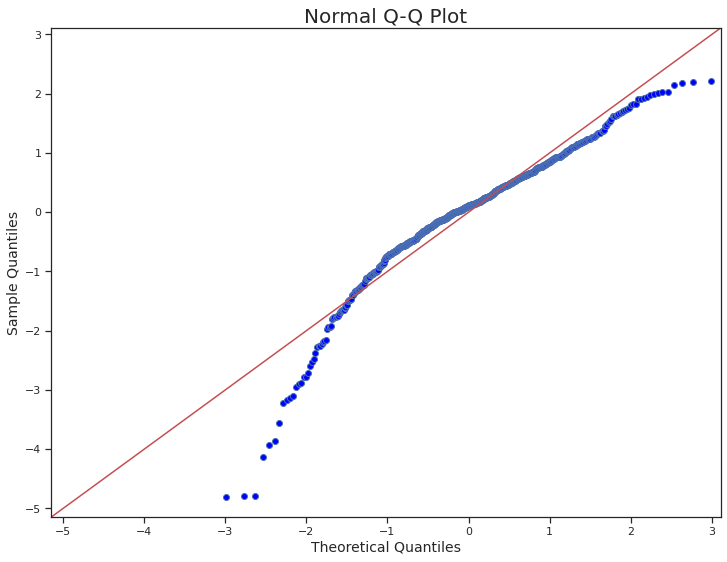

In [ ]:
#Q-Q plot for the log transformed data
qqplot(data = loglm.resid, fit = True, line = "45")
plt.title("Normal Q-Q Plot", fontsize = 20)
plt.xlabel("Theoretical Quantiles", fontsize = 14)
plt.ylabel("Sample Quantiles", fontsize = 14)
plt.show()

There is still a heavy tail on the data, implying that the normality assumption is still violated with the log transformed data. We will attempt to fix this with another transformation, namely, the box-cox transformation.

### <font size = "4"> **Box-Cox Transformation**

The box-cox transformation looks to find the optimal value for an exponent variable $λ$. This optimal value of $λ$ is the value of  $λ$ that when applied to the response most closely resembles a normal curve (when plotted) 

In [ ]:
#Apply the box-cox transformation to the response
transformed_data, lambda_value = boxcox(poke["weight_kg"])
lambda_value

0.1282783009904318

We have found  $λ$ = 0.128278, and have applied this value to the response. We will now create a data frame with the transformed data and see if this data satisfies the assumption of linear regression. After the creation of the data frame we will fit a linear model to the transformed data. This model will be referred to as model 3.

In [ ]:
box_cox_data = poke.copy()

#Create a column with the transformed data
box_cox_data["transformed_weight_kg"] = transformed_data

#Drop the original data from the data frame
box_cox_data.drop("weight_kg", axis = 1, inplace = True)

box_cox_data.head()

,height_m,hp,attack,defense,speed,transformed_weight_kg
name,,,,,,
Bulbasaur,0.7,45,49,49,45,2.191861
Ivysaur,1.0,60,62,63,60,3.037270
Venusaur,2.0,80,100,123,80,6.277991
Charmander,0.6,39,52,43,65,2.462647
Charmeleon,1.1,58,64,58,80,3.577661


In [ ]:
#Create a linear model with the transformed data
boxlm = ols("transformed_weight_kg ~ height_m + hp + attack + defense + speed", data = box_cox_data).fit()
boxlm_summary = boxlm.summary()
print(boxlm_summary)

                              OLS Regression Results                             
Dep. Variable:     transformed_weight_kg   R-squared:                       0.556
Model:                               OLS   Adj. R-squared:                  0.552
Method:                    Least Squares   F-statistic:                     176.5
Date:                   Wed, 04 Jan 2023   Prob (F-statistic):          1.02e-121
Time:                           18:28:46   Log-Likelihood:                -1235.3
No. Observations:                    712   AIC:                             2483.
Df Residuals:                        706   BIC:                             2510.
Df Model:                              5                                         
Covariance Type:               nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.4052 

Once again we will note that the $R^{2}$ improved to 0.556 compared to the log transformed model which had a $R^{2}$ value of 0.507 and the original model with an $R^{2}$ of 0.463. We now examine the normal Q-Q plot for the box-cox transformed data.


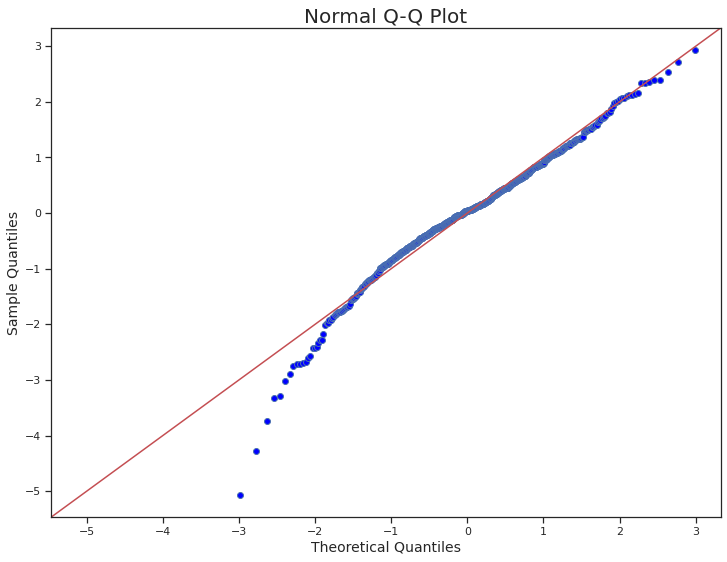

In [ ]:
#Q-Q plot for box-cox transformed data
qqplot(data = boxlm.resid, fit = True, line = "45")
plt.title("Normal Q-Q Plot", fontsize = 20)
plt.xlabel("Theoretical Quantiles", fontsize = 14)
plt.ylabel("Sample Quantiles", fontsize = 14)
plt.show()

We will now look at the normal Q-Q plot for model 3. Comparing this to the normal Q-Q plot for model 1 we see a vast improvement. The tails are not as severe, in fact in the upper portion of the plot the points now lie approximately on the line. There is still some issue with the bottom portion of the plot but it has been severely reduced, and looks as though it is the result of a few outliers. 
<br>
<br>
Now we will inspect the residuals versus fitted values plot for model 3.

In [ ]:
#Calculate the predicted values and residual
box_cox_data["fitted_values"] = boxlm.predict(box_cox_data[predictors])
box_cox_data["residual"] = box_cox_data["transformed_weight_kg"] - box_cox_data["fitted_values"]

box_cox_data.head()

,height_m,hp,attack,defense,speed,transformed_weight_kg,fitted_values,residual
name,,,,,,,,
Bulbasaur,0.7,45,49,49,45,2.191861,2.508861,-0.317000
Ivysaur,1.0,60,62,63,60,3.037270,3.444460,-0.407190
Venusaur,2.0,80,100,123,80,6.277991,6.105653,0.172338
Charmander,0.6,39,52,43,65,2.462647,2.255283,0.207365
Charmeleon,1.1,58,64,58,80,3.577661,3.423166,0.154495


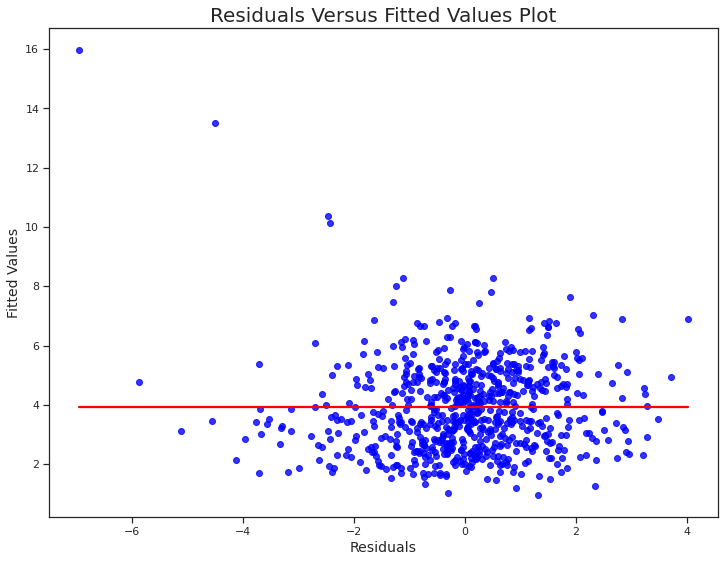

In [ ]:
#Create residual verus fitted values plot
sns.set(rc = {'figure.figsize': (12, 9)})
sns.set_style("ticks")
sns.regplot(x = box_cox_data["residual"], y = box_cox_data["fitted_values"], ci = None, scatter_kws = {"color":"blue"}, line_kws = {"color":"red"})
plt.title("Residuals Versus Fitted Values Plot", fontsize = 20)
plt.xlabel("Residuals", fontsize = 14)
plt.ylabel("Fitted Values", fontsize = 14)
plt.show()

The residuals versus fitted values plot for model 3 looks much better when compared to model 1’s residual versus fitted values plot. The points seem to be scattered randomly about the line, we appear to have constant variance, and there are no clear signs of non-linearity.
<br>
<br>
Therefore, for model 2 we can say that none of our assumptions for linear regression are violated. Thus, we may now look at the appropriate hypothesis tests and construct joint confidence intervals for the coefficients.
<br>
<br>
Looking back to the summary for model 3, we see that the p-value for testing the significance of regression is $1.02\times10^{-102}$ , thus we can conclude that there is a linear relationship between the transformed Pokemon’s weight and at least one of a Pokemon's height, hp, attack, defense, or speed. Further we see that only speed does not significantly contribute to the model given the other predictor variables are in the model. We will now obtain 95% joint confidence intervals for the coefficients using the Bonferroni method of correction.

In [ ]:
#Create dataframe with coefficients and their standard error
coefficients = boxlm.params
standarderror = boxlm.bse
joint_ci_df = pd.DataFrame([coefficients, standarderror]).transpose()
joint_ci_df.columns = ["coefficients", "std_error"]
joint_ci_df

,coefficients,std_error
Intercept,-0.405172,0.214890
height_m,0.754531,0.065807
hp,0.020035,0.002358
attack,0.014675,0.002129
defense,0.015912,0.002037
speed,-0.000323,0.002011


In [ ]:
#Obtain 95% joint confidence intervals for the coefficients
t_stat = stats.t.ppf(1 - ((0.05/6) / 2), 706)
joint_ci_df["lower_bound"] = joint_ci_df["coefficients"] - (t_stat * joint_ci_df["std_error"])
joint_ci_df["upper_bound"] = joint_ci_df["coefficients"] + (t_stat * joint_ci_df["std_error"])
joint_ci_df[["coefficients", "lower_bound", "upper_bound"]]

,coefficients,lower_bound,upper_bound
Intercept,-0.405172,-0.973710,0.163366
height_m,0.754531,0.580425,0.928636
hp,0.020035,0.013796,0.026275
attack,0.014675,0.009043,0.020308
defense,0.015912,0.010524,0.021301
speed,-0.000323,-0.005643,0.004997


## <font size = "6"> **Leverage and Influence Points**

We now analyze the outliers in our dataset. To do this we calculate a variety of diagnostics for each data point including the diagonals of the hat matrix, Cook’s distance, DFFITS, and the COVRATIO as well as their cutoff values.

In [ ]:
#Create dataframe with various diagnostics
influence_df = pd.DataFrame(box_cox_data["transformed_weight_kg"])
influence = boxlm.get_influence()
influence_df["h_ii"] = influence.hat_diag_factor
influence_df["cooks_distance"] = influence.cooks_distance[0]
influence_df["dffits"] = influence.dffits[0]
influence_df["covratio"] = influence.cov_ratio
influence_df.head()

,transformed_weight_kg,h_ii,cooks_distance,dffits,covratio
name,,,,,
Bulbasaur,2.191861,0.003600,0.000032,-0.013822,1.011714
Ivysaur,3.037270,0.001716,0.000025,-0.012247,1.009520
Venusaur,6.277991,0.006748,0.000018,0.010304,1.015210
Charmander,2.462647,0.003958,0.000015,0.009482,1.012337
Charmeleon,3.577661,0.002542,0.000005,0.005657,1.010996


We first look to find points of leverage in the dataset. These are points that are remote in the x space. We find these points by comparing the diagonals of the hat matrix to a cutoff value $\frac{2p}{n}$. In our dataset we find there are 34 points of leverage. The largest points of leverage appear to be Chansey, Blissey, Onix, Steelix, and Wailord.

In [ ]:
#Obtain cutoff value for the diagonals of the hat matrix and display points of leverage
p = poke.shape[1] + 1
n = poke.shape[0]
h_ii_diagonal_cutoff = (2 * p) / n
leverage_points = influence_df[influence_df["h_ii"] > h_ii_diagonal_cutoff]
leverage_points["h_ii"]

name
Beedrill      0.024839
Wigglytuff    0.019817
Alakazam      0.022013
Slowbro       0.028139
Cloyster      0.025553
Onix          0.186453
Electrode     0.022135
Chansey       0.144007
Gyarados      0.059905
Snorlax       0.027933
Dragonair     0.022757
Wobbuffet     0.058114
Steelix       0.173676
Shuckle       0.087630
Heracross     0.022372
Blissey       0.145465
Slaking       0.023151
Ninjask       0.020184
Shedinja      0.020469
Hariyama      0.020052
Aggron        0.044848
Wailord       0.622354
Milotic       0.061747
Rampardos     0.022286
Bastiodon     0.025637
Drifblim      0.022823
Happiny       0.020618
Munchlax      0.027790
Alomomola     0.030397
Aegislash     0.021168
Carbink       0.021840
Avalugg       0.024515
Wishiwashi    0.022293
Dhelmise      0.023657
Name: h_ii, dtype: float64

The next thing we want to identify are potential points of influence. We will first use Cook’s distance to identify influential points. We look for any data points that have a value of Cook’s distance greater than 1.. There is only one data point that satisfies the condition, that point being Wailord with a Cook’s distance of 4.2866.

In [ ]:
#Obtain points that have a Cook's distance > 1
influential_points_c_d = influence_df[influence_df["cooks_distance"] > 1]
influential_points_c_d["cooks_distance"]

name
Wailord    4.286579
Name: cooks_distance, dtype: float64

We also gather data points that of DFFITS where the absolute value of DFFITS exceeds the cutoff value of $2\sqrt{\frac{p}{n}}$ (Appendix Figure 2). It is worth noting that the largest values of DFFITS by far are Wailord and Steelix. 

In [ ]:
#Obtain cutoff value for DFFITS and display points that exceed the value
dffits_cutoff = 2 * math.sqrt(p/n)
dffits_above_cutoff = influence_df[abs(influence_df["dffits"]) > dffits_cutoff]
dffits_above_cutoff["dffits"]

name
Wigglytuff   -0.202054
Abra          0.200116
Kadabra       0.234848
Gastly       -0.303410
Haunter      -0.336808
Onix         -0.833466
Electrode     0.225290
Chansey      -0.319258
Gyarados     -0.453938
Snorlax       0.282944
Dragonair    -0.300286
Igglybuff    -0.207544
Wobbuffet    -0.287041
Steelix      -1.489284
Mantine       0.219549
Blissey      -0.341275
Shedinja     -0.216103
Nosepass      0.238927
Wailord      -5.223015
Milotic      -0.206504
Banette      -0.237876
Metagross     0.279460
Bastiodon     0.214168
Drifblim     -0.234913
Munchlax      0.212545
Probopass     0.343534
Rotom        -0.329591
Alomomola    -0.233196
Cryogonal     0.230827
Doublade     -0.338032
Spritzee     -0.219925
Carbink      -0.214599
Avalugg       0.216906
Ribombee     -0.275258
Wishiwashi   -0.652167
Mudsdale      0.307626
Comfey       -0.310432
Pyukumuku    -0.339567
Mimikyu      -0.220512
Name: dffits, dtype: float64

Lastly we obtain data points whose COVRATIO that are either below $1 - \frac{3p}{n}$ or above $1 + \frac{3p}{n}$. Again, Steelix and Wailord both have significant values. Thus our outlier analysis allows us to conclude that both Wailord and Steelix are two very influential points in the data set.

In [ ]:
#Obtain cutoff value for COVRATIO and display values that exceed value
covratio_cutoff = 1 + ((3 * p) / n)
covratio_above_cutoff = influence_df[influence_df["covratio"] > covratio_cutoff]
covratio_above_cutoff["covratio"].to_frame("covratio").reset_index()

,name,covratio
0,Beedrill,1.033394
1,Slowbro,1.033769
2,Cloyster,1.031035
3,Onix,1.159337
4,Chansey,1.146853
5,Gyarados,1.038192
6,Wobbuffet,1.054365
7,Steelix,1.062825
8,Shuckle,1.095219
9,Blissey,1.147408


## <font size = "6"> **Multicollinearity**

Finally we want to determine if there is any multicollinearity in the data, as if there is we may need to reduce the model or perform ridge regression. We will first calculate the correlation matrix.

In [ ]:
#Correlation matrix for the predictor variables
predictor_df = poke[predictors]
correlation_matrix = predictor_df.corr(method = "pearson").round(4)
correlation_matrix

,height_m,hp,attack,defense,speed
height_m,1.0000,0.4039,0.3823,0.3531,0.1538
hp,0.4039,1.0000,0.3712,0.1909,0.1001
attack,0.3823,0.3712,1.0000,0.4467,0.2925
defense,0.3531,0.1909,0.4467,1.0000,-0.0545
speed,0.1538,0.1001,0.2925,-0.0545,1.0000


The correlation matrix for the predictors has no high values of correlation between any of the predictors. The correlation matrix shows no signs of multicollinearity, but alone does not confirm the absence of multicollinearity. We will inspect the variance inflation factors of the predictor variables to ensure our data has no problems with multicollinearity.

In [ ]:
#Get the design matrix
X = dmatrices("weight_kg ~ height_m + hp + attack + defense + speed", data = poke, return_type = "dataframe")[1]

#Get the VIFs
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns
vif = vif[["variable", "VIF"]]
vif[~(vif["variable"] == "Intercept")]

,variable,VIF
1,height_m,1.373991
2,hp,1.282736
3,attack,1.603355
4,defense,1.391518
5,speed,1.160309


The summary of variance inflation factors consists of VIFs that are 
well below values of concern. Thus, our dataset has no significant problems with multicollinearity.

## <font size = "6"> **Conclusion**

We found that model $1$ is not an adequate model to predict Pokemon weight as both the linearity and normality assumptions are violated. This could lead to predictions with incredibly high variance, and does not allow us to perform the usual hypothesis tests on the coefficients. To alleviate these violations we used a box-cox transformation on Pokemon weight, and achieved a model that does not violate any assumptions of linear regression. Model $3$ had an $R^{2}$  value of $0.556$ implying that $55.6\%$ of the variation in the transformed Pokemon’s weight is explained by the model. When testing for the significance of regression we found that at least one of height, hp, attack, defense, and speed contributed to the model. It should also be noted that all variables with the exception of speed were statistically significant given the other variables were in the model. The data set contained two major points of influence, those being Steelix and Wailord, and there seems to be no significant multicollinearity in the data.